In [1]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

# git pull | git add . | git commit -m "update" | git push

In [2]:
# Read the file

df_cfb = pd.read_csv('CollegeFootballRankings24to20.csv')
df_cfb.head()



FileNotFoundError: [Errno 2] No such file or directory: 'CollegeFootballRankings24to20.csv'

In [ ]:
# Create a boxplot comparing passing and rushing yards.
df_cfb_long = pd.melt(df_cfb, value_vars=['pass', 'rush', 'rec'], var_name='type', value_name='yards')

df_cfb_long['yards'] = pd.to_numeric(df_cfb_long['yards'], errors='coerce')

sb.boxplot(data=df_cfb_long, x='type', y='yards')

plt.title('Passing versus Rushing yards')
plt.xlabel('Type of play')
plt.ylabel('Yards gained')

plt.show()

In [ ]:
# Create a scatterplot of point scored at home vs. away.
sb.kdeplot(data=df_cfb, x='points_scored',  fill = True, hue = 'home_game')

plt.title('Points scored at home vs. away')
plt.xlabel('Points scored')
plt.ylabel('Density')

labels = ['Home', 'Away']
plt.legend(title='Location', labels=labels)    

plt.show()

In [ ]:
# Create a scatterplot of point allowed at home vs. away.
sb.kdeplot(data=df_cfb, x='points_allowed',  fill = True, hue = 'home_game')

plt.title('Points allowed at home vs. away')
plt.xlabel('Points allowed')
plt.ylabel('Density')

labels = ['Home', 'Away']
plt.legend(title='Location', labels=labels)    

plt.show()

In [ ]:
sb.kdeplot(data=df_cfb, x='points_scored',  fill = True, hue = 'CONF', alpha = 0.05)

plt.title('Points scored in each conference')
plt.xlabel('Points scored')
plt.ylabel('Density')

#labels = ['Home', 'Away']
#plt.legend(title='Location', labels=labels)    

plt.show()


In [ ]:
import pandas as pd
import numpy as np

# --- 1. Data Loading and Cleaning ---
# Load the dataset
df = pd.read_csv('03 - Cleaned Data Space/mergedTrainingData.csv')

# --- 2. Date Parsing and Sorting for Chronology ---
# The original 'date' column is missing the year. We combine it with 'season' for correct parsing.
df.rename(columns={'win_loss': 'Result'}, inplace=True)

# 2a. Create a full date string: 'Month Day, Year'
# We use a regex check to ensure we only try to parse valid game dates (e.g., 'Sat, Nov 16')
df['full_date_str'] = np.where(
    df['date'].astype(str).str.contains(r'^[A-Za-z]{3},\s[A-Za-z]{3}\s\d{1,2}$', na=False),
    df['date'].astype(str).str.split(',').str[-1].str.strip() + ', ' + df['season'].astype(str),
    np.nan
)

# 2b. Convert to datetime object and handle non-game rows (like 'Bye')
df['game_date'] = pd.to_datetime(df['full_date_str'], errors='coerce')

# Filter for games that have a 'Win' or 'Loss' result and valid dates/differentials
df_games = df[df['Result'].isin(['W', 'L'])].dropna(subset=['game_date', 'point_differential'])

# Convert point_differential to numeric
df_games['point_differential'] = pd.to_numeric(df_games['point_differential'])

# Sort the DataFrame by the actual game date (Crucial for sequential Elo updates)
df_games.sort_values(by='game_date', inplace=True)

# Reset index to make iteration cleaner
df_games.reset_index(drop=True, inplace=True)


# --- 3. Elo Rating System Implementation ---

# Initialize Elo ratings for all teams
initial_elo = 1500
elo_ratings = {}

# K-factor (determines the magnitude of rating change)
K = 32

def calculate_elo_change(r_a, r_b, result, point_differential, k_factor):
    """
    Calculates the change in Elo rating for Team A, including a Margin of Victory (MoV) adjustment.
    """
    # 1. Expected Win Probability (E_A) for Team A
    e_a = 1 / (1 + 10**((r_b - r_a) / 400))

    # 2. Actual Score (S_A): 1 for Win, 0 for Loss
    s_a = 1 if result == 'W' else 0

    # 3. Margin of Victory (MoV) Multiplier
    # This is a simple adjustment to increase the K-factor for blowouts.
    # It is a common simplified MoV adjustment that scales by the point difference.
    mov_multiplier = np.log(abs(point_differential) + 1) * 2.2 / (abs(r_a - r_b) / 400 + 2.2)
    # Clamp the multiplier to prevent extreme changes on massive blowouts
    mov_multiplier = np.clip(mov_multiplier, 0.5, 3.0)

    # 4. Final Elo Change Formula: K' * (S_A - E_A)
    delta_elo = k_factor * mov_multiplier * (s_a - e_a)

    return delta_elo

# List to store the Elo ratings for merging back later
elo_history = []

# Populate initial ratings dictionary
all_teams = pd.concat([df_games['Team'], df_games['opponent']]).unique()
for team in all_teams:
    elo_ratings[team] = initial_elo

# Iterate through each game chronologically
for index, row in df_games.iterrows():
    team_a = row['Team']
    team_b = row['opponent']
    result_a = row['Result']
    diff = row['point_differential']

    # Retrieve current ratings (will be initial_elo if it's the team's first game)
    r_a = elo_ratings.get(team_a, initial_elo)
    r_b = elo_ratings.get(team_b, initial_elo)

    # Calculate Elo change for Team A
    delta_a = calculate_elo_change(r_a, r_b, result_a, diff, K)

    # Elo is a zero-sum system: Team B's change is the negative of Team A's
    delta_b = -delta_a

    # Calculate new ratings
    new_r_a = r_a + delta_a
    new_r_b = r_b + delta_b

    # Store the POST-GAME Elo rating for Team A in the history
    elo_history.append({
        'game_date': row['game_date'],
        'Team': team_a,
        'Team_Elo_Rating': new_r_a
    })

    # Update the ratings dictionary for the next game
    elo_ratings[team_a] = new_r_a
    elo_ratings[team_b] = new_r_b


# --- 4. Final Merge and Output ---

# Convert the history to a DataFrame
elo_df = pd.DataFrame(elo_history)

# Merge the new Elo ratings back into the original game data
final_df = df_games.merge(elo_df, on=['game_date', 'Team'], how='left')

# Select and display the relevant columns to show the result
final_output = final_df[[
    'season', 'game_date', 'Team', 'opponent', 'Result',
    'point_differential', 'Team_Elo_Rating'
]].sort_values(by=['game_date', 'Team'])

print("\n--- Final Output Sample (First 10 Games) ---")
print(final_output.head(10).to_string(index=False))

# Save the final DataFrame
final_output.to_csv('College_Football_Elo_Rankings.csv', index=False)

In [11]:
# Initialize Elo history list
elo_history = []

import pandas as pd
import numpy as np

# --- 1. Data Loading and Cleaning ---
# Load the dataset
df = pd.read_csv('03 - Cleaned Data Space/mergedTrainingData.csv')

# --- 2. Date Parsing and Sorting for Chronology ---
# The original 'date' column is missing the year. We combine it with 'season' for correct parsing.
df.rename(columns={'win_loss': 'Result'}, inplace=True)

# 2a. Create a full date string: 'Month Day, Year'
# We use a regex check to ensure we only try to parse valid game dates (e.g., 'Sat, Nov 16')
df['full_date_str'] = np.where(
    df['date'].astype(str).str.contains(r'^[A-Za-z]{3},\s[A-Za-z]{3}\s\d{1,2}$', na=False),
    df['date'].astype(str).str.split(',').str[-1].str.strip() + ', ' + df['season'].astype(str),
    np.nan
)

# 2b. Convert to datetime object and handle non-game rows (like 'Bye')
df['game_date'] = pd.to_datetime(df['full_date_str'], errors='coerce')

# Filter for games that have a 'Win' or 'Loss' result and valid dates/differentials
df_games = df[df['Result'].isin(['W', 'L'])].dropna(subset=['game_date', 'point_differential'])

# Convert point_differential to numeric
df_games['point_differential'] = pd.to_numeric(df_games['point_differential'])

# Sort the DataFrame by the actual game date (Crucial for sequential Elo updates)
df_games.sort_values(by='game_date', inplace=True)

# Reset index to make iteration cleaner
df_games.reset_index(drop=True, inplace=True)


# Sort by season and game_date
df_games.sort_values(by=['season', 'game_date'], inplace=True)
df_games.reset_index(drop=True, inplace=True)

df_games['team_pair'] = df_games.apply(lambda x: '_'.join(sorted([x['Team'], x['opponent']])), axis=1)
df_games = df_games.sort_values('game_date').drop_duplicates(subset=['game_date', 'team_pair'], keep='first')
df_games.reset_index(drop=True, inplace=True)

start_date = pd.Timestamp('2021-09-03')
df_games = df_games[df_games['game_date'] >= start_date].copy()
df_games.reset_index(drop=True, inplace=True)


# Parameters
initial_elo = 1500
K = 32

# Iterate season by season
for season, season_df in df_games.groupby('season'):
    # --- 1. Reset Elo ratings for this season ---
    teams_in_season = pd.concat([season_df['Team'], season_df['opponent']]).unique()
    elo_ratings = {team: initial_elo for team in teams_in_season}

    # --- 2. Process games in chronological order ---
    season_df = season_df.sort_values(by='game_date')
    
    for _, row in season_df.iterrows():
        team_a = row['Team']
        team_b = row['opponent']
        result_a = row['Result']
        diff = row['point_differential']

        # Pre-game Elo
        r_a = elo_ratings.get(team_a, initial_elo)
        r_b = elo_ratings.get(team_b, initial_elo)

        # Calculate Elo change
        e_a = 1 / (1 + 10 ** ((r_b - r_a) / 400))
        s_a = 1 if result_a == 'W' else 0
        mov_mult = np.log(abs(diff) + 1) * 2.2 / ((abs(r_a - r_b) / 400) + 2.2)
        mov_mult = np.clip(mov_mult, 0.5, 3.0)
        delta_a = K * mov_mult * (s_a - e_a)
        delta_b = -delta_a

        # Post-game Elo
        new_r_a = r_a + delta_a
        new_r_b = r_b + delta_b

        elo_history.append({
            'season': season,
            'game_date': row['game_date'],
            'Team': team_a,
            'opponent': team_b,
            'Result': result_a,
            'point_differential': diff,
            'Pre_Elo_Team': r_a,
            'Pre_Elo_Opponent': r_b,
            'Post_Elo_Team': new_r_a,
            'Post_Elo_Opponent': new_r_b,
            'Elo_Change': delta_a
        })

        # Add mirror entry for the opponent’s side
        elo_history.append({
            'season': season,
            'game_date': row['game_date'],
            'Team': team_b,
            'opponent': team_a,
            'Result': 'W' if result_a == 'L' else 'L',
            'point_differential': -diff,
            'Pre_Elo_Team': r_b,
            'Pre_Elo_Opponent': r_a,
            'Post_Elo_Team': new_r_b,
            'Post_Elo_Opponent': new_r_a,
            'Elo_Change': delta_b
        })

        # Update ratings
        elo_ratings[team_a] = new_r_a
        elo_ratings[team_b] = new_r_b

# Convert to DataFrame
elo_df = pd.DataFrame(elo_history)
elo_df.sort_values(by=['season', 'game_date'], inplace=True)
elo_df.reset_index(drop=True, inplace=True)

# Save results
elo_df.to_csv('College_Football_Elo_Rankings_PerSeason.csv', index=False)

print("\n--- Sample Output ---")
print(elo_df.head(10).to_string(index=False))



--- Sample Output ---
 season  game_date             Team         opponent Result  point_differential  Pre_Elo_Team  Pre_Elo_Opponent  Post_Elo_Team  Post_Elo_Opponent  Elo_Change
   2021 2021-09-04 New Mexico State  San Diego State      L                 -18        1500.0            1500.0    1452.888976        1547.111024  -47.111024
   2021 2021-09-04  San Diego State New Mexico State      W                  18        1500.0            1500.0    1547.111024        1452.888976   47.111024
   2021 2021-09-04             UCLA              LSU      W                  11        1500.0            1500.0    1539.758506        1460.241494   39.758506
   2021 2021-09-04              LSU             UCLA      L                 -11        1500.0            1500.0    1460.241494        1539.758506  -39.758506
   2021 2021-09-04         Illinois             UTSA      L                  -7        1500.0            1500.0    1466.728935        1533.271065  -33.271065
   2021 2021-09-04           

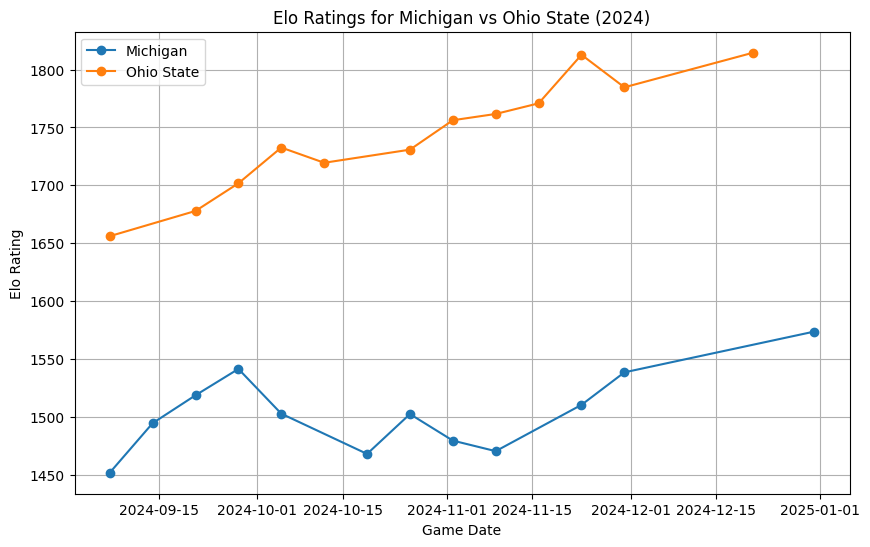

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'game_date' is a datetime
df_games['game_date'] = pd.to_datetime(df_games['game_date'], errors='coerce')

# Define a function that maps each date to its "season year"
def assign_season(date):
    # Season runs from Sept 1 of year N to Feb 1 of year N+1
    if pd.Timestamp(date.month) >= pd.Timestamp(9):  # Sept - Dec
        return date.year
    else:  # Jan - Feb (counts as previous year's season)
        return date.year - 1

df_games['season'] = df_games['game_date'].apply(assign_season)


# --- Load the data ---
elo_df = pd.read_csv('College_Football_Elo_Rankings_PerSeason.csv', parse_dates=['game_date'])

# --- Pick season and teams ---
selected_season = 2024
home_team = "Michigan"
away_team = "Ohio State"

# --- Filter data ---

start = pd.Timestamp(f"{selected_season}-09-01")
end = pd.Timestamp(f"{selected_season + 1}-02-01")

team_elo = elo_df[
    (elo_df['game_date'] >= start) &
    (elo_df['game_date'] <= end) &
    (elo_df['Team'].isin([home_team, away_team]))
].copy()

team_elo = team_elo[['game_date', 'Team', 'Post_Elo_Team']]
team_elo.rename(columns={'Post_Elo_Team': 'Elo'}, inplace=True)

# --- Plot with Matplotlib ---
plt.figure(figsize=(10, 6))
for team in [home_team, away_team]:
    team_data = team_elo[team_elo['Team'] == team]
    plt.plot(team_data['game_date'], team_data['Elo'], marker='o', label=team)

plt.title(f"Elo Ratings for {home_team} vs {away_team} ({selected_season})")
plt.xlabel("Game Date")
plt.ylabel("Elo Rating")
plt.legend()
plt.grid(True)
plt.show()
